Total number of centerline files: 79
Minimum centerline length: 59.22610621769467
Maximum centerline length: 98.56068770545313
Average centerline length: 75.07954866493863


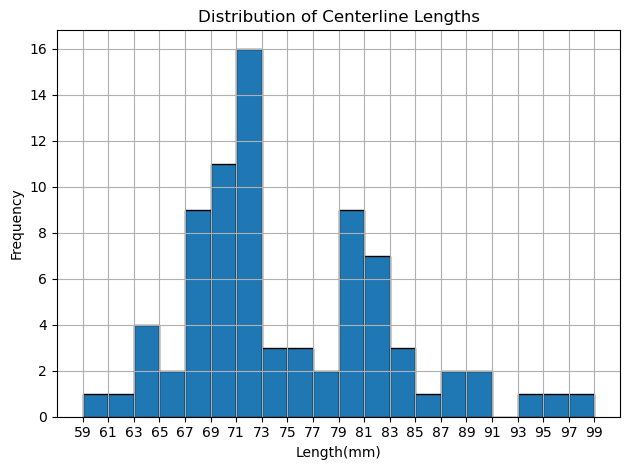

In [16]:
import os
import vtk
import numpy as np
import matplotlib.pyplot as plt

def compute_length_from_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    lines = polydata.GetLines()
    lines.InitTraversal()
    id_list = vtk.vtkIdList()
    total_length = 0.0

    while lines.GetNextCell(id_list):
        for i in range(id_list.GetNumberOfIds() - 1):
            pt1 = np.array(points.GetPoint(id_list.GetId(i)))
            pt2 = np.array(points.GetPoint(id_list.GetId(i + 1)))
            total_length += np.linalg.norm(pt2 - pt1)
    return total_length

# 替换为你的目录路径
vtk_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\cut"
vtk_files = [f for f in os.listdir(vtk_dir) if f.endswith(".vtk")]

lengths = []

for file in vtk_files:
    file_path = os.path.join(vtk_dir, file)
    length = compute_length_from_vtk(file_path)
    lengths.append(length)

# 打印统计信息
print("Total number of centerline files:", len(lengths))
print("Minimum centerline length:", np.min(lengths))
print("Maximum centerline length:", np.max(lengths))
print("Average centerline length:", np.mean(lengths))

# -----------------------------
# 绘图部分：横轴整数间隔，边界对齐
min_val = int(np.floor(np.min(lengths)))
max_val = int(np.ceil(np.max(lengths)))
step = 2  # 你可以根据需要修改为 2 或 10

bins = np.arange(min_val, max_val + step, step)

counts, bins, patches = plt.hist(lengths, bins=bins, edgecolor='black', rwidth=1.0)
plt.xticks(bins)  # 横轴刻度与柱子边界对齐

plt.title("Distribution of Centerline Lengths")
plt.xlabel("Length(mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


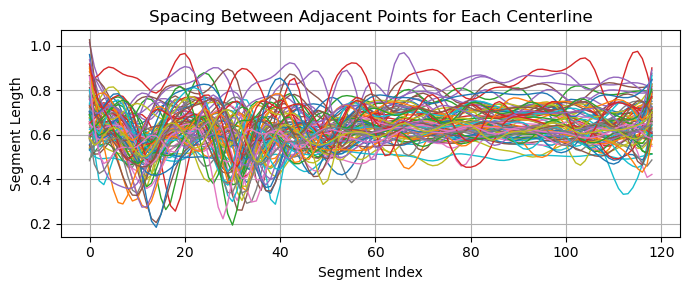

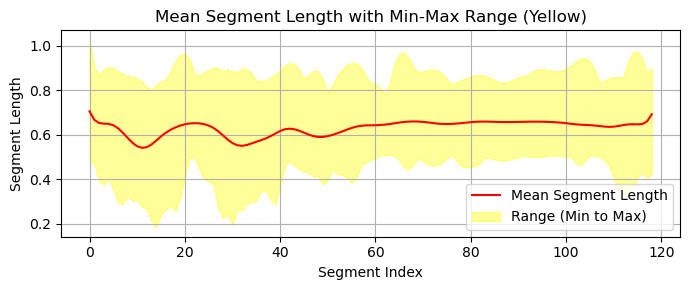

In [24]:
import os
import vtk
import numpy as np
import matplotlib.pyplot as plt
import glob

# 设置你的VTK文件夹路径
vtk_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\cut"
vtk_files = glob.glob(os.path.join(vtk_dir, "*.vtk"))

# 存储每条中心线的点间距数据
segment_data = {}

for file_path in vtk_files:
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    if not points or points.GetNumberOfPoints() < 2:
        continue

    distances = []
    for i in range(points.GetNumberOfPoints() - 1):
        p1 = np.array(points.GetPoint(i))
        p2 = np.array(points.GetPoint(i + 1))
        d = np.linalg.norm(p2 - p1)
        distances.append(d)

    name = os.path.basename(file_path).replace(".vtk", "")
    segment_data[name] = distances

# 第一张图：每条中心线的 segment length 曲线
plt.figure(figsize=(7, 3))
for name, dists in segment_data.items():
    plt.plot(range(len(dists)), dists, label=name, linewidth=1)

plt.xlabel("Segment Index")
plt.ylabel("Segment Length")
plt.title("Spacing Between Adjacent Points for Each Centerline")
plt.grid(True)
plt.tight_layout()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="x-small")
plt.show()

# 第二张图：平均值 + min-max 区间（黄色）
# 仅保留长度一致的中心线
max_len = max(len(v) for v in segment_data.values())
valid_lines = [v for v in segment_data.values() if len(v) == max_len]
arr = np.array(valid_lines)

mean_d = np.mean(arr, axis=0)
min_d = np.min(arr, axis=0)
max_d = np.max(arr, axis=0)

# 可视化：黄色区域表示 max-min 区间
plt.figure(figsize=(7, 3))
plt.plot(range(max_len), mean_d, color='red', label='Mean Segment Length')
plt.fill_between(range(max_len), min_d, max_d,
                 color='yellow', alpha=0.4, label='Range (Min to Max)')

plt.xlabel("Segment Index")
plt.ylabel("Segment Length")
plt.title("Mean Segment Length with Min-Max Range (Yellow)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 中心线出口入口延长

In [2]:
import numpy as np
import os

def interpolate_polyline_fixed(points, fixed_n=300):
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cum_dist = np.insert(np.cumsum(distances), 0, 0)
    total_length = cum_dist[-1]
    target_d = np.linspace(0, total_length, fixed_n)

    interpolated = []
    j = 0
    for d in target_d:
        while j < len(cum_dist) - 2 and d > cum_dist[j + 1]:
            j += 1
        t = (d - cum_dist[j]) / (cum_dist[j+1] - cum_dist[j])
        p = (1 - t) * points[j] + t * points[j + 1]
        interpolated.append(p)
    return np.array(interpolated)

def extend_and_resample_to_fixed_ascii(input_path, output_path, extend_entry=12, extend_exit=22, fixed_n=180, spacing=0.6):
    # 读取 ASCII VTK 中心线文件（Legacy）
    with open(input_path, 'r') as f:
        lines = f.readlines()

    # 找到 POINTS 和 LINES 起始行
    points_start = [i for i, line in enumerate(lines) if line.startswith("POINTS")][0]
    lines_start = [i for i, line in enumerate(lines) if line.startswith("LINES")][0]

    num_points = int(lines[points_start].split()[1])
    point_lines = lines[points_start + 1 : lines_start]
    points = np.array([float(x) for line in point_lines for x in line.strip().split()]).reshape(-1, 3)

    # 延长入口和出口
    entry_dir = points[1] - points[0]
    entry_dir /= np.linalg.norm(entry_dir)
    exit_dir = points[-1] - points[-2]
    exit_dir /= np.linalg.norm(exit_dir)

    n_entry = int(extend_entry / spacing)
    n_exit = int(extend_exit / spacing)

    entry_ext = [points[0] - i * spacing * entry_dir for i in range(n_entry, 0, -1)]
    exit_ext = [points[-1] + i * spacing * exit_dir for i in range(1, n_exit + 1)]

    extended_coords = np.vstack([entry_ext, points, exit_ext])

    # 重采样为固定点数
    resampled = interpolate_polyline_fixed(extended_coords, fixed_n)

    # 写入 ASCII VTK（Legacy）
    with open(output_path, 'w') as f:
        # 头部复制
        for i in range(points_start):
            f.write(lines[i])

        # 写 POINTS
        f.write(f"POINTS {fixed_n} float\n")
        for pt in resampled:
            f.write(f"{pt[0]} {pt[1]} {pt[2]}\n")

        # 写 LINES
        f.write(f"LINES 1 {fixed_n + 1}\n")
        f.write(f"{fixed_n} " + ' '.join(str(i) for i in range(fixed_n)) + '\n')

    print(f"[OK] {os.path.basename(input_path)} → {os.path.basename(output_path)} | {fixed_n} points")

# 批量处理路径
input_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\cut"
output_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\long_fixed300"
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(input_dir) if f.endswith(".vtk")]
print(f"Found {len(files)} files.\n")

for fname in files:
    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)
    extend_and_resample_to_fixed_ascii(in_path, out_path)


Found 80 files.

[OK] BG0001_ICA_L.vtk → BG0001_ICA_L.vtk | 180 points
[OK] BG0001_ICA_R.vtk → BG0001_ICA_R.vtk | 180 points
[OK] BG0004_ICA_L.vtk → BG0004_ICA_L.vtk | 180 points
[OK] BG0004_ICA_R.vtk → BG0004_ICA_R.vtk | 180 points
[OK] BG0006_ICA_L.vtk → BG0006_ICA_L.vtk | 180 points
[OK] BG0006_ICA_R.vtk → BG0006_ICA_R.vtk | 180 points
[OK] BG0007_ICA_L.vtk → BG0007_ICA_L.vtk | 180 points
[OK] BG0007_ICA_R.vtk → BG0007_ICA_R.vtk | 180 points
[OK] BG0008_ICA_L.vtk → BG0008_ICA_L.vtk | 180 points
[OK] BG0008_ICA_R.vtk → BG0008_ICA_R.vtk | 180 points
[OK] BG0009_ICA_L.vtk → BG0009_ICA_L.vtk | 180 points
[OK] BG0009_ICA_R.vtk → BG0009_ICA_R.vtk | 180 points
[OK] BG0010_ICA_L.vtk → BG0010_ICA_L.vtk | 180 points
[OK] BG0010_ICA_R.vtk → BG0010_ICA_R.vtk | 180 points
[OK] BG0011_ICA_L.vtk → BG0011_ICA_L.vtk | 180 points
[OK] BG0011_ICA_R.vtk → BG0011_ICA_R.vtk | 180 points
[OK] BG0012_ICA_L.vtk → BG0012_ICA_L.vtk | 180 points
[OK] BG0012_ICA_R.vtk → BG0012_ICA_R.vtk | 180 points
[OK] BG0017

## 增加半径(1.5mm)

In [3]:
import os

# 目录路径
input_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\long_fixed300"
output_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300"

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取所有 VTK 文件
vtk_files = [f for f in os.listdir(input_dir) if f.endswith(".vtk")]

for file_name in vtk_files:
    input_file = os.path.join(input_dir, file_name)
    output_file = os.path.join(output_dir, file_name)  # 保持原文件名

    # 读取原始文件内容
    with open(input_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # 查找 POINTS 行，提取点的数量
    num_points = None
    for line in lines:
        if line.strip().startswith("POINTS"):
            num_points = int(line.split()[1])
            break

    if num_points is None:
        print(f"⚠️ 未能找到 POINTS 定义，跳过文件: {file_name}")
        continue

    # 生成新的 POINT_DATA 部分
    radius_section = [
        f"\nPOINT_DATA {num_points}\n",
        "SCALARS MaximumInscribedSphereRadius float\n",
        "LOOKUP_TABLE default\n",
    ] + [f"1.5\n" for _ in range(num_points)]

    # 将新的数据追加到原始内容
    with open(output_file, "w", encoding="utf-8") as f:
        f.writelines(lines)  # 写入原始内容
        f.writelines(radius_section)  # 追加新的数据部分

    print(f"✅ 处理完成: {file_name}")

print(f"\n🎉 所有 VTK 文件已成功添加半径，并保存到: {output_dir}")


✅ 处理完成: BG0001_ICA_L.vtk
✅ 处理完成: BG0001_ICA_R.vtk
✅ 处理完成: BG0004_ICA_L.vtk
✅ 处理完成: BG0004_ICA_R.vtk
✅ 处理完成: BG0006_ICA_L.vtk
✅ 处理完成: BG0006_ICA_R.vtk
✅ 处理完成: BG0007_ICA_L.vtk
✅ 处理完成: BG0007_ICA_R.vtk
✅ 处理完成: BG0008_ICA_L.vtk
✅ 处理完成: BG0008_ICA_R.vtk
✅ 处理完成: BG0009_ICA_L.vtk
✅ 处理完成: BG0009_ICA_R.vtk
✅ 处理完成: BG0010_ICA_L.vtk
✅ 处理完成: BG0010_ICA_R.vtk
✅ 处理完成: BG0011_ICA_L.vtk
✅ 处理完成: BG0011_ICA_R.vtk
✅ 处理完成: BG0012_ICA_L.vtk
✅ 处理完成: BG0012_ICA_R.vtk
✅ 处理完成: BG0017_ICA_L.vtk
✅ 处理完成: BG0017_ICA_R.vtk
✅ 处理完成: BG0018_ICA_L.vtk
✅ 处理完成: BG0018_ICA_R.vtk
✅ 处理完成: BG0019_ICA_L.vtk
✅ 处理完成: BG0019_ICA_R.vtk
✅ 处理完成: BG0020_ICA_L.vtk
✅ 处理完成: BG0020_ICA_R.vtk
✅ 处理完成: BG0021_ICA_R.vtk
✅ 处理完成: BG0022_ICA_L.vtk
✅ 处理完成: BG0022_ICA_R.vtk
✅ 处理完成: BH0005_ICA_L.vtk
✅ 处理完成: BH0005_ICA_R.vtk
✅ 处理完成: BH0006_ICA_L.vtk
✅ 处理完成: BH0006_ICA_R.vtk
✅ 处理完成: BH0009_ICA_L.vtk
✅ 处理完成: BH0009_ICA_R.vtk
✅ 处理完成: BH0010_ICA_L.vtk
✅ 处理完成: BH0010_ICA_R.vtk
✅ 处理完成: BH0011_ICA_L.vtk
✅ 处理完成: BH0011_ICA_R.vtk
✅ 处理完成: BH0013_ICA_L.vtk


## vmtk

In [ ]:
import os

# 输入和输出文件夹路径
input_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed180"
output_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\stl_fixed180"
output_script = r"D:\PhD Research\F_Research\F_fugaku\Research\vmtk_batch_commands_fixed180.txt"

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取所有 .vtk 文件
vtk_files = [f for f in os.listdir(input_dir) if f.endswith(".vtk")]

# VMTK 处理参数
dimensions = "128 128 128"

# 生成 VMTK 命令
commands = []
for file_name in vtk_files:
    input_file = os.path.join(input_dir, file_name).replace("\\", "/")  # 转换为 VMTK 兼容路径
    output_file = os.path.join(output_dir, file_name.replace(".vtk", "_tube.stl")).replace("\\", "/")

    command = f'vmtkcenterlinemodeller -ifile "{input_file}" -radiusarray MaximumInscribedSphereRadius -dimensions {dimensions} --pipe vmtkmarchingcubes -ofile "{output_file}"'
    commands.append(command)

# 将命令写入 TXT 文件
with open(output_script, "w", encoding="utf-8") as f:
    f.write("\n".join(commands))

print(f"✅ VMTK 批量命令已生成，保存至: {output_script}")
print("📋 请打开 TXT 文件，复制命令并粘贴到 VMTK 终端运行！")


✅ VMTK 批量命令已生成，保存至: D:\PhD Research\F_Research\F_fugaku\Research\vmtk_batch_commands_fixed180.txt
📋 请打开 TXT 文件，复制命令并粘贴到 VMTK 终端运行！


: 

In [4]:
import os
import vtk

def vtk_to_txt(vtk_file_path, txt_file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()
    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    num_points = points.GetNumberOfPoints()

    with open(txt_file_path, 'w', encoding='utf-8') as f:
        f.write(f"#pt3d {num_points}\n")
        for i in range(num_points):
            x, y, z = points.GetPoint(i)
            f.write(f"{x:.6f} {y:.6f} {z:.6f}\n")

def batch_convert_vtk_to_txt(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".vtk"):
            vtk_path = os.path.join(input_dir, filename)
            txt_filename = os.path.splitext(filename)[0] + ".txt"
            txt_path = os.path.join(output_dir, txt_filename)
            print(f"Converting: {vtk_path} -> {txt_path}")
            vtk_to_txt(vtk_path, txt_path)

# 指定输入输出路径
input_directory = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300"
output_directory = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\txt300"

batch_convert_vtk_to_txt(input_directory, output_directory)


Converting: D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300\BG0001_ICA_L.vtk -> D:\PhD Research\F_Research\F_fugaku\Research\centerline\txt300\BG0001_ICA_L.txt
Converting: D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300\BG0001_ICA_R.vtk -> D:\PhD Research\F_Research\F_fugaku\Research\centerline\txt300\BG0001_ICA_R.txt
Converting: D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300\BG0004_ICA_L.vtk -> D:\PhD Research\F_Research\F_fugaku\Research\centerline\txt300\BG0004_ICA_L.txt
Converting: D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300\BG0004_ICA_R.vtk -> D:\PhD Research\F_Research\F_fugaku\Research\centerline\txt300\BG0004_ICA_R.txt
Converting: D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300\BG0006_ICA_L.vtk -> D:\PhD Research\F_Research\F_fugaku\Research\centerline\txt300\BG0006_ICA_L.txt
Converting: D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed300\BG0006_I

In [43]:
input_file = r"D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed180\BH0016_ICA_L.vtk"
output_file = r"D:\PhD Research\F_Research\F_fugaku\Research\stl_fixed180\BH0016_ICA_L_tube.stl"
dimensions = "128 128 128"

command = f'vmtkcenterlinemodeller -ifile "{input_file}" -radiusarray MaximumInscribedSphereRadius -dimensions {dimensions} --pipe vmtkmarchingcubes -ofile "{output_file}"'

# 保存为 TXT 或直接运行
#print("请在 VMTK 终端中运行以下命令：\n")
print(command)


vmtkcenterlinemodeller -ifile "D:\PhD Research\F_Research\F_fugaku\Research\centerline\edit_fixed180\BH0016_ICA_L.vtk" -radiusarray MaximumInscribedSphereRadius -dimensions 128 128 128 --pipe vmtkmarchingcubes -ofile "D:\PhD Research\F_Research\F_fugaku\Research\stl_fixed180\BH0016_ICA_L_tube.stl"


## 文档名

In [4]:
import os
import pandas as pd

# 目标文件夹路径
stl_dir = r"D:\PhD Research\F_Research\F_fugaku\Research\stl"
output_csv = r"D:\PhD Research\F_Research\F_fugaku\Research\USCV_class.csv"

# 确保文件夹存在
if not os.path.exists(stl_dir):
    print(f"❌ 目录不存在: {stl_dir}")
    exit()

# 获取所有 STL 文件名（去掉 .stl 后缀）并按字母顺序排序
stl_files = sorted([os.path.splitext(f)[0] for f in os.listdir(stl_dir) if f.endswith(".stl")])

# 如果目录为空
if not stl_files:
    print(f"⚠️ 目录 '{stl_dir}' 中没有 STL 文件")
    exit()

# 创建 DataFrame
df = pd.DataFrame(stl_files, columns=["File Name"])

# 保存到 CSV，竖着写
df.to_csv(output_csv, index=False, header=False)

print(f"✅ 文件名已保存到 {output_csv}（无后缀）")


✅ 文件名已保存到 D:\PhD Research\F_Research\F_fugaku\Research\USCV_class.csv（无后缀）
